In [2]:
!pip -q install -U mediapipe opencv-python pretty_midi numpy matplotlib
!apt-get -qq install ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 53.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have

In [7]:
import os

!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task -O hand_landmarker.task

MODEL_PATH = os.path.abspath("hand_landmarker.task")
print("Model exists:", os.path.exists(MODEL_PATH))
print("Model size:", os.path.getsize(MODEL_PATH), "bytes")


Model exists: True
Model size: 7819105 bytes


In [8]:
from google.colab import files

uploaded = files.upload()
VIDEO_PATH = next(iter(uploaded.keys()))
print("VIDEO_PATH:", VIDEO_PATH)

Saving 9.senfoni_righthand_sena.mp4 to 9.senfoni_righthand_sena.mp4
VIDEO_PATH: 9.senfoni_righthand_sena.mp4


Imports+Config

In [9]:
import cv2
import numpy as np
import mediapipe as mp
import pretty_midi
from dataclasses import dataclass
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# --- ROI & bands (your current values) ---
ROI = (0, 77, 848, 403)
N_WHITE_KEYS = 11

BRIGHTNESS_BAND = (0.60, 0.98)  # lower part of keys
BLACK_BAND = (0.05, 0.55)       # upper part (black keys)

# MIDI octave guess (try 3/4/5 if octave is shifted)
OCTAVE_GUESS = 4

# Threshold calibration
PRESS_PCT = 16
RELEASE_PCT = 55
EMA_ALPHA = 0.05

# Temporal logic
STABLE_FRAMES = 3
MIN_HOLD_MS = 80
COOLDOWN_MS = 200
NEIGHBOR_TOL = 1

OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)
OUTPUT_DEBUG_VIDEO = os.path.join(OUT_DIR, "debug_overlay.mp4")
OUTPUT_DEBUG_FIXED = os.path.join(OUT_DIR, "debug_overlay_fixed.mp4")
OUTPUT_MIDI = os.path.join(OUT_DIR, "output.mid")
OUTPUT_LABELED_FRAME = os.path.join(OUT_DIR, "frame_labeled.png")


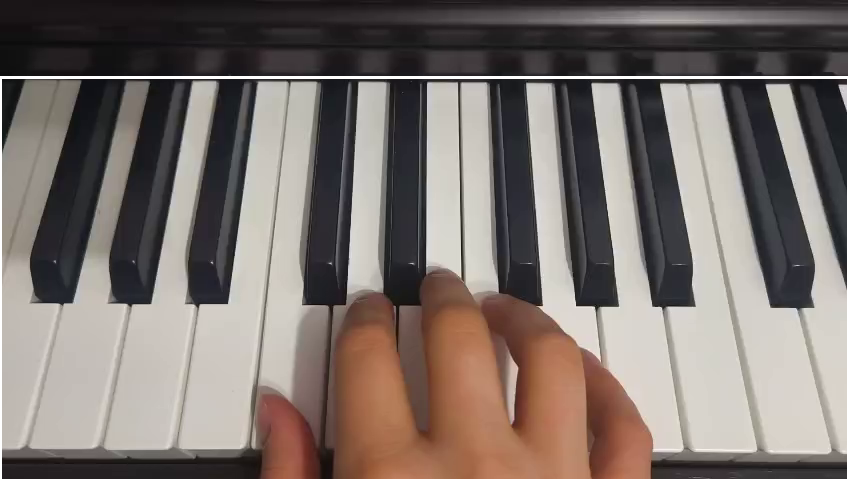

Saved: outputs/first_frame_roi.png shape: (480, 848, 3)


In [10]:
from IPython.display import Image, display

def get_first_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")
    while True:
        ret, fr = cap.read()
        if not ret:
            cap.release()
            raise RuntimeError("No readable frames in the video.")
        cap.release()
        return fr

fr0 = get_first_frame(VIDEO_PATH)
img = fr0.copy()
x,y,w,h = ROI
cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,255), 2)

tmp = os.path.join(OUT_DIR, "first_frame_roi.png")
cv2.imwrite(tmp, img)
display(Image(tmp))
print("Saved:", tmp, "shape:", fr0.shape)


Black key detection(robust) + debug mask visualization

Detected black key centers: 9 [77.0, 149.0, 221.0, 386.5, 514.0, 586.0, 657.0, 769.0, 821.0]


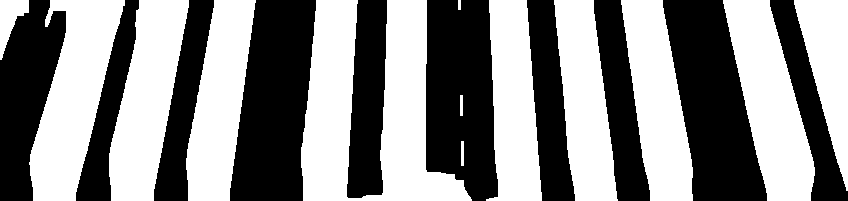

Saved: outputs/black_mask.png


In [11]:
def roi_band_crop(frame_bgr, roi, band):
    x,y,w,h = roi
    b0,b1 = band
    y0 = int(y + b0*h); y1 = int(y + b1*h)
    crop = frame_bgr[y0:y1, x:x+w]
    return crop, (x,y0,w,y1-y0)

def detect_black_key_centers(frame_bgr, roi, band=BLACK_BAND, min_area=250):
    """
    Robust black key detection using Otsu threshold (automatic).
    Returns black key x-centers in global coordinates.
    """
    crop, (x0,y0,w,h) = roi_band_crop(frame_bgr, roi, band)
    if crop.size == 0:
        return [], None

    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

    # Improve contrast (helps in bad lighting)
    gray_blur = cv2.GaussianBlur(gray, (5,5), 0)

    # Otsu: automatic threshold, then invert (black keys become white blobs)
    _, bw = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Morphology to clean noise
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, np.ones((7,7), np.uint8), iterations=2)

    cnts, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centers = []
    H,W = bw.shape[:2]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_area:
            continue
        x,y,ww,hh = cv2.boundingRect(c)

        # shape filters: black keys are relatively tall and narrow
        if hh < 0.30 * H:
            continue
        if ww < 0.01 * W or ww > 0.25 * W:
            continue

        cx_local = x + ww/2
        centers.append(x0 + cx_local)

    centers = sorted(centers)
    return centers, bw

black_x, bwmask = detect_black_key_centers(fr0, ROI, BLACK_BAND)
print("Detected black key centers:", len(black_x), black_x[:10])

# Save debug image showing the mask
if bwmask is not None:
    dbg = cv2.cvtColor(bwmask, cv2.COLOR_GRAY2BGR)
    tmp2 = os.path.join(OUT_DIR, "black_mask.png")
    cv2.imwrite(tmp2, dbg)
    display(Image(tmp2))
    print("Saved:", tmp2)


v2 centers: 10 [77.5, 149.0, 221.0, 329.5, 415.0, 515.5, 585.5, 657.0, 769.0, 821.5]


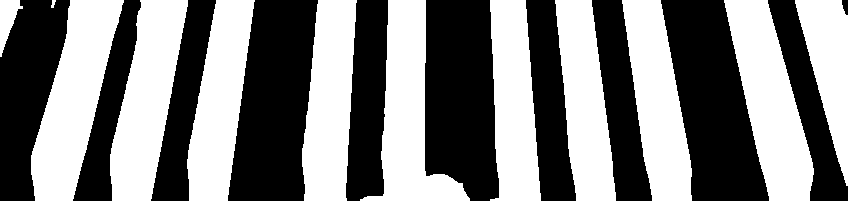

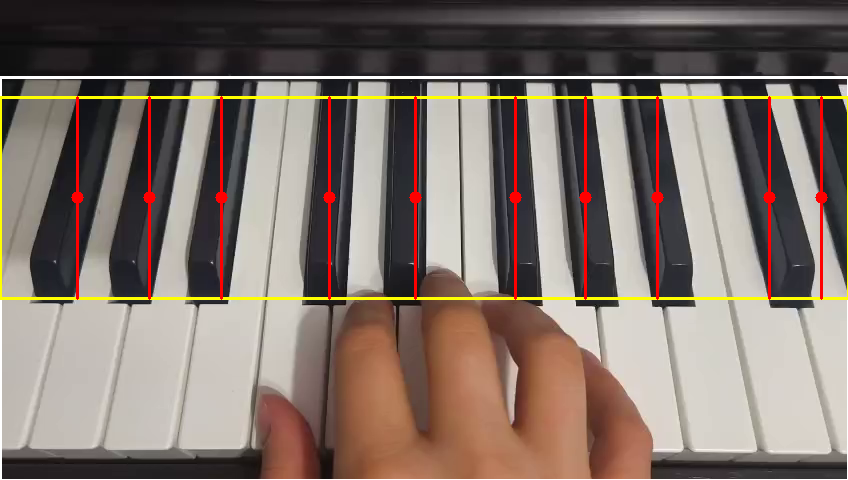

Saved: outputs/black_centers_overlay_v2.png


In [13]:
def detect_black_key_centers_v2(frame_bgr, roi, band=BLACK_BAND, min_area=200):
    crop, (x0,y0,w,h) = roi_band_crop(frame_bgr, roi, band)
    if crop.size == 0:
        return [], None

    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Break thin connections (this is the key change)
    bw = cv2.morphologyEx(bw, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=2)
    bw = cv2.erode(bw, np.ones((3,3), np.uint8), iterations=1)

    cnts, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centers = []
    H,W = bw.shape[:2]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_area:
            continue
        x,y,ww,hh = cv2.boundingRect(c)

        # tighter shape constraints
        if hh < 0.35 * H:
            continue
        if ww < 0.01 * W or ww > 0.18 * W:  # narrower max width than before
            continue

        centers.append(x0 + (x + ww/2))

    centers = sorted(centers)
    return centers, bw

black_x2, bwmask2 = detect_black_key_centers_v2(fr0, ROI, BLACK_BAND)
print("v2 centers:", len(black_x2), black_x2[:10])

tmp = os.path.join(OUT_DIR, "black_mask_v2.png")
cv2.imwrite(tmp, bwmask2)
display(Image(tmp))

overlay_path2 = draw_black_centers_on_frame(fr0, ROI, BLACK_BAND, black_x2, out_path="outputs/black_centers_overlay_v2.png")
display(Image(overlay_path2))
print("Saved:", overlay_path2)


Create White Labels (C/F Anchor)

In [15]:
WHITE_SEQ = ["C","D","E","F","G","A","B"]

def infer_white_labels_from_black_pattern_robust(black_centers_x, roi, n_white):
    labels = [None] * n_white
    if len(black_centers_x) < 2:
        return labels, None, None, None

    black_centers_x = np.array(sorted(black_centers_x), dtype=np.float32)
    dx = np.diff(black_centers_x)
    med = float(np.median(dx))

    x, y, w, h = roi
    white_w = w / n_white

    def x_to_bin(px):
        idx = int(np.floor((px - x) / white_w))
        return max(0, min(n_white - 1, idx))

    def split_into_groups(th):
        groups = []
        cur = [float(black_centers_x[0])]
        for i, d in enumerate(dx):
            if float(d) > th:
                groups.append(cur)
                cur = [float(black_centers_x[i+1])]
            else:
                cur.append(float(black_centers_x[i+1]))
        groups.append(cur)
        return groups

    # Score a grouping: prefer having many 2/3 groups and avoid 1-length groups
    def score_groups(groups):
        lens = [len(g) for g in groups]
        n23 = sum([1 for L in lens if L in (2,3)])
        n1  = sum([1 for L in lens if L == 1])
        # higher is better
        return 10*n23 - 3*n1 - abs(len(groups)-3)  # typical pattern gives ~3-4 groups in view

    best = None
    for factor in np.linspace(1.2, 2.5, 14):
        th = factor * med
        groups = split_into_groups(th)
        sc = score_groups(groups)
        cand = (sc, factor, th, groups)
        if (best is None) or (cand[0] > best[0]):
            best = cand

    sc, factor, th, groups = best
    lens = [len(g) for g in groups]

    # Find anchor:
    # - prefer 2-group => C anchor (left of first black in that group)
    # - else 3-group => F anchor
    anchor = None

    # helper: choose the leftmost 2-group or 3-group (more stable)
    idx_2 = next((i for i,L in enumerate(lens) if L == 2), None)
    idx_3 = next((i for i,L in enumerate(lens) if L == 3), None)

    if idx_2 is not None:
        left_black = groups[idx_2][0]
        px = left_black - 0.6 * white_w
        anchor = ("C", x_to_bin(px))
    elif idx_3 is not None:
        left_black = groups[idx_3][0]
        px = left_black - 0.6 * white_w
        anchor = ("F", x_to_bin(px))
    else:
        # fallback: if no clean 2/3 group, use the biggest gap positions to create groups
        anchor = None

    if anchor is None:
        return labels, None, (dx.tolist(), med), (lens, factor)

    note_name, anchor_idx = anchor
    base_pos = WHITE_SEQ.index(note_name)

    for k in range(n_white):
        offset = k - anchor_idx
        labels[k] = WHITE_SEQ[(base_pos + offset) % 7]

    return labels, anchor, (dx.tolist(), med), (lens, factor)


labels, anchor, dx_info, dbg = infer_white_labels_from_black_pattern_robust(black_x2, ROI, N_WHITE_KEYS)
print("Anchor:", anchor)
print("Labels:", labels)

if dx_info is not None:
    dx_list, med = dx_info
    print("dx:", [round(v,1) for v in dx_list], "median:", round(med,1))

if dbg is not None:
    lens, factor = dbg
    print("group sizes:", lens, "chosen factor:", round(float(factor),2))


Anchor: ('C', 3)
Labels: ['G', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'A', 'B', 'C']
dx: [71.5, 72.0, 108.5, 85.5, 100.5, 70.0, 71.5, 112.0, 52.5] median: 72.0
group sizes: [3, 2, 3, 2] chosen factor: 1.2


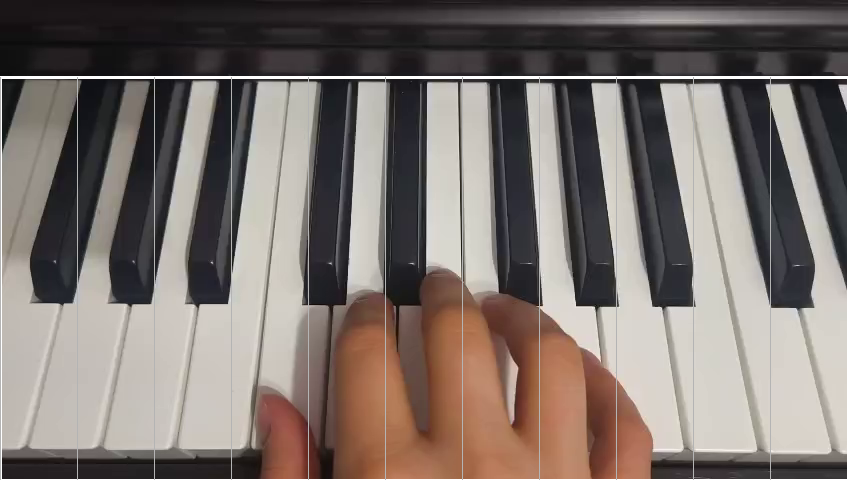

Saved: outputs/frame_labeled.png


In [16]:
labeled_path = save_labeled_frame(fr0, ROI, N_WHITE_KEYS, labels, out_path="outputs/frame_labeled.png")
display(Image(labeled_path))
print("Saved:", labeled_path)


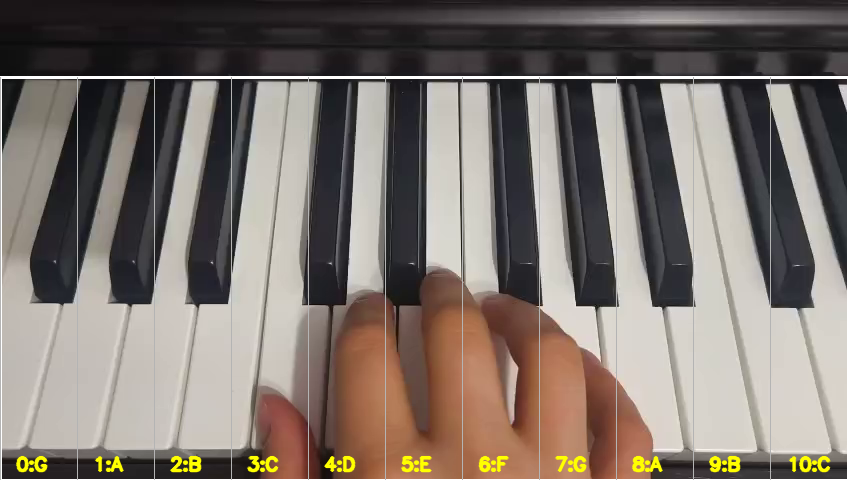

Saved: outputs/frame_labeled_bottom.png


In [17]:
def save_labeled_frame_bottom(frame_bgr, roi, n_white, labels, out_path="outputs/frame_labeled_bottom.png"):
    img = frame_bgr.copy()
    H, W = img.shape[:2]
    x, y, w, h = roi

    # ROI
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 255, 255), 2)

    # Where to write text? Try below ROI first
    text_y = y + h + 28
    put_below = (text_y < H - 5)

    for k in range(n_white):
        x0, x1 = key_x_bounds(roi, n_white, k)
        cx = (x0 + x1) // 2
        lab = labels[k] if labels[k] else "?"

        # draw bin borders
        cv2.line(img, (x0, y), (x0, y + h), (180, 180, 180), 1)
        if k == n_white - 1:
            cv2.line(img, (x1, y), (x1, y + h), (180, 180, 180), 1)

        # decide text position
        if put_below:
            tx, ty = cx - 22, text_y
        else:
            # fallback: write INSIDE ROI near the bottom
            tx, ty = cx - 22, y + h - 10

        cv2.putText(
            img, f"{k}:{lab}",
            (tx, ty),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6, (0, 255, 255), 2, cv2.LINE_AA
        )

    cv2.imwrite(out_path, img)
    return out_path

path = save_labeled_frame_bottom(fr0, ROI, N_WHITE_KEYS, labels)
display(Image(path))
print("Saved:", path)


Fallback + MIDI pitch functions

In [18]:
# If inference still produced many None, use a temporary fallback
WHITE_SEQ = ["C","D","E","F","G","A","B"]
NOTE_TO_PC = {"C":0,"D":2,"E":4,"F":5,"G":7,"A":9,"B":11}

if sum([l is None for l in labels]) > N_WHITE_KEYS//2:
    labels = [WHITE_SEQ[k % 7] for k in range(N_WHITE_KEYS)]
    print("WARNING: using fallback labels:", labels)

def midi_pitch_from_label(label, octave):
    """Convert note name (C..B) + octave guess -> MIDI pitch. Example: C4=60."""
    if label not in NOTE_TO_PC:
        return None
    return int((octave + 1) * 12 + NOTE_TO_PC[label])

print("Labels used:", labels)
print("Example pitches:", [(k, labels[k], midi_pitch_from_label(labels[k], OCTAVE_GUESS)) for k in range(min(7, N_WHITE_KEYS))])


Labels used: ['G', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'A', 'B', 'C']
Example pitches: [(0, 'G', 67), (1, 'A', 69), (2, 'B', 71), (3, 'C', 60), (4, 'D', 62), (5, 'E', 64), (6, 'F', 65)]


Brightness Tracker + Treshold Calibration

In [19]:
class KeyBrightnessTracker:
    """Tracks per-key brightness (mean) and returns per-key z-score."""
    def __init__(self, roi, n_keys, band, alpha):
        self.x, self.y, self.w, self.h = roi
        self.n = n_keys
        b0, b1 = band
        self.y0 = int(self.y + b0 * self.h)
        self.y1 = int(self.y + b1 * self.h)
        self.alpha = alpha
        self.mu = np.zeros(self.n, dtype=np.float32)
        self.var = np.ones(self.n, dtype=np.float32) * 25.0
        self.init_done = False

    def measure(self, gray):
        band_img = gray[self.y0:self.y1, self.x:self.x + self.w]
        vals = np.zeros(self.n, dtype=np.float32)
        if band_img.size == 0:
            return vals
        for k in range(self.n):
            x0 = int(k * (self.w / self.n))
            x1 = int((k + 1) * (self.w / self.n))
            patch = band_img[:, x0:x1]
            if patch.size:
                vals[k] = float(np.mean(patch))
        return vals

    def update(self, vals):
        if not self.init_done:
            self.mu = vals.copy()
            self.init_done = True
        self.mu = (1 - self.alpha) * self.mu + self.alpha * vals
        resid = vals - self.mu
        self.var = (1 - self.alpha) * self.var + self.alpha * (resid * resid)
        std = np.sqrt(np.maximum(self.var, 1e-6))
        z = (vals - self.mu) / std
        return z

def calibrate_thresholds(video_path, roi, n_keys, band, seconds=3, press_pct=PRESS_PCT, release_pct=RELEASE_PCT):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    T = int(seconds * fps)

    tr = KeyBrightnessTracker(roi, n_keys, band, EMA_ALPHA)
    Z = []
    for _ in range(T):
        ret, fr = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        z = tr.update(tr.measure(gray))
        Z.append(z)
    cap.release()

    if len(Z) < 5:
        press_th = np.ones(n_keys, np.float32) * (-1.0)
        rel_th = np.ones(n_keys, np.float32) * (-0.2)
        return press_th, rel_th

    Z = np.stack(Z, axis=0)
    press_th = np.percentile(Z, press_pct, axis=0).astype(np.float32)
    rel_th   = np.percentile(Z, release_pct, axis=0).astype(np.float32)
    return press_th, rel_th

press_th, rel_th = calibrate_thresholds(VIDEO_PATH, ROI, N_WHITE_KEYS, BRIGHTNESS_BAND, seconds=3)
print("press_th:", float(np.min(press_th)), float(np.median(press_th)), float(np.max(press_th)))
print("rel_th:  ", float(np.min(rel_th)),   float(np.median(rel_th)),   float(np.max(rel_th)))


press_th: -1.356317162513733 -1.1452343463897705 -0.34188881516456604
rel_th:   -0.7495108246803284 -0.596735954284668 0.6344993114471436


MediaPipe hand landmarker setup

In [20]:
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

BaseOptions = python.BaseOptions
hand_options = vision.HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=MODEL_PATH),
    running_mode=vision.RunningMode.IMAGE,
    num_hands=2,
    min_hand_detection_confidence=0.1,
    min_hand_presence_confidence=0.1,
)

def pick_right_hand(result):
    """Pick right hand if present; otherwise take first hand."""
    if (not result) or (not result.hand_landmarks):
        return None
    if result.handedness:
        for i, cats in enumerate(result.handedness):
            best = max(cats, key=lambda c: c.score)
            if best.category_name.lower() == "right":
                return result.hand_landmarks[i]
    return result.hand_landmarks[0]


## MAIN run() function :  events + debug video + MIDI

In [26]:
from dataclasses import dataclass

FINGER_TIPS = {"index": 8, "middle": 12, "ring": 16}

def key_index_from_point(px, py, roi, n_keys):
    x, y, w, h = roi
    if px < x or px >= x+w or py < y or py >= y+h:
        return None
    idx = int(np.floor((px - x) / (w / n_keys)))
    return max(0, min(n_keys - 1, idx))

@dataclass
class PressEvent:
    pitch: int
    onset_s: float
    offset_s: float
    finger: str
    key_idx: int
    label: str

class FingerState:
    def __init__(self):
        self.last_key = None
        self.streak = 0
        self.is_pressed = False
        self.press_start = None
        self.active_key = None
        self.active_pitch = None
        self.cooldown_until = 0.0

def run(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    dt = 1.0 / fps

    bright = KeyBrightnessTracker(ROI, N_WHITE_KEYS, BRIGHTNESS_BAND, EMA_ALPHA)
    states = {f: FingerState() for f in FINGER_TIPS}
    events = []

    out = None
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    frame_idx = 0

    with vision.HandLandmarker.create_from_options(hand_options) as landmarker:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if out is None:
                H, W = frame.shape[:2]
                out = cv2.VideoWriter(OUTPUT_DEBUG_VIDEO, fourcc, fps, (W, H))

            t = frame_idx * dt

            # Per-key z-score
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            z = bright.update(bright.measure(gray))

            # Hand
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = landmarker.detect(mp.Image(image_format=mp.ImageFormat.SRGB, data=np.ascontiguousarray(rgb)))
            hand = pick_right_hand(res)

            # ROI
            x, y, w, h = ROI
            cv2.rectangle(frame, (x,y), (x+w,y+h), (255,255,255), 2)

            # Draw key labels (top)
            for k in range(N_WHITE_KEYS):
                x0, x1 = key_x_bounds(ROI, N_WHITE_KEYS, k)
                cx = (x0+x1)//2
                lab = labels[k] if labels[k] else "?"
                cv2.putText(frame, f"{k}:{lab}", (cx-18, y-8),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255,255,0), 1, cv2.LINE_AA)

            if hand is not None:
                Hh, Ww = frame.shape[:2]
                for fname, tip_idx in FINGER_TIPS.items():
                    st = states[fname]
                    tip = hand[tip_idx]
                    px, py = int(tip.x * Ww), int(tip.y * Hh)
                    cv2.circle(frame, (px,py), 6, (0,255,0), -1)

                    key_idx = key_index_from_point(px, py, ROI, N_WHITE_KEYS)

                    # Out of ROI => force release
                    if key_idx is None:
                        if st.is_pressed:
                            off = t
                            if (off - st.press_start) * 1000 >= MIN_HOLD_MS:
                                events.append(PressEvent(st.active_pitch, st.press_start, off, fname, st.active_key, labels[st.active_key] or "?"))
                        states[fname] = FingerState()
                        continue

                    # Stability streak
                    if key_idx == st.last_key:
                        st.streak += 1
                    else:
                        st.last_key = key_idx
                        st.streak = 1

                    # Neighborhood best key (darkest z)
                    k0 = max(0, key_idx - NEIGHBOR_TOL)
                    k1 = min(N_WHITE_KEYS - 1, key_idx + NEIGHBOR_TOL)
                    best_k = min(range(k0, k1+1), key=lambda k: z[k])
                    best_z = float(z[best_k])

                    lab = labels[best_k]
                    pitch = midi_pitch_from_label(lab, OCTAVE_GUESS) if lab else None

                    # PRESS
                    press_ok = (
                        (not st.is_pressed) and
                        (t >= st.cooldown_until) and
                        (st.streak >= STABLE_FRAMES) and
                        (pitch is not None) and
                        (best_z < float(press_th[best_k]))
                    )
                    if press_ok:
                        st.is_pressed = True
                        st.press_start = t
                        st.active_key = best_k
                        st.active_pitch = pitch

                    # RELEASE
                    if st.is_pressed:
                        k_rel = st.active_key
                        if float(z[k_rel]) > float(rel_th[k_rel]):
                            off = t
                            if (off - st.press_start) * 1000 >= MIN_HOLD_MS:
                                events.append(PressEvent(st.active_pitch, st.press_start, off, fname, st.active_key, labels[st.active_key] or "?"))
                            st.is_pressed = False
                            st.press_start = None
                            st.active_key = None
                            st.active_pitch = None
                            st.cooldown_until = t + COOLDOWN_MS / 1000.0

                    # Visualize chosen key
                    x0, x1 = key_x_bounds(ROI, N_WHITE_KEYS, best_k)
                    cv2.rectangle(frame, (x0, y), (x1, y+h), (0,255,255), 2)
                    cv2.putText(frame, f"z={best_z:.2f}", (x0, y-25),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,255,255), 1)

            cv2.putText(frame, f"events={len(events)}", (20,40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

            out.write(frame)
            frame_idx += 1

    cap.release()
    if out:
        out.release()

    # MIDI
    pm = pretty_midi.PrettyMIDI()
    inst = pretty_midi.Instrument(program=0)
    for ev in events:
        inst.notes.append(pretty_midi.Note(
            velocity=90,
            pitch=int(ev.pitch),
            start=float(ev.onset_s),
            end=max(float(ev.offset_s), float(ev.onset_s)+0.01)
        ))
    pm.instruments.append(inst)
    pm.write(OUTPUT_MIDI)

    print("Saved debug video:", OUTPUT_DEBUG_VIDEO)
    print("Saved MIDI:", OUTPUT_MIDI)
    return events, fps

events, fps = run(VIDEO_PATH)
print("FPS:", fps, "Events:", len(events))


Saved debug video: outputs/debug_overlay.mp4
Saved MIDI: outputs/output.mid
FPS: 30.004521639488587 Events: 41


In [22]:
import pretty_midi
import numpy as np

def midi_num_to_name(midi_num: int) -> str:
    # pretty_midi already has this helper, but let's keep it explicit
    return pretty_midi.note_number_to_name(int(midi_num))

def print_events_table(events, max_rows=200):
    if not events:
        print("No events to print (events is empty).")
        return

    print(f"Total events: {len(events)}")
    print("idx | finger | key_idx | label | pitch | note_name | onset(s) | offset(s) | dur(ms)")
    print("-"*90)
    for i, ev in enumerate(events[:max_rows]):
        dur_ms = (ev.offset_s - ev.onset_s) * 1000.0
        print(f"{i:3d} | {ev.finger:6s} | {ev.key_idx:6d} | {ev.label:5s} | {ev.pitch:5d} | "
              f"{midi_num_to_name(ev.pitch):8s} | {ev.onset_s:7.3f} | {ev.offset_s:8.3f} | {dur_ms:7.1f}")
    if len(events) > max_rows:
        print(f"... (showing first {max_rows})")

def print_midi_file_notes(midi_path="outputs/output.mid", max_rows=300):
    pm = pretty_midi.PrettyMIDI(midi_path)
    notes = []
    for inst_i, inst in enumerate(pm.instruments):
        for n in inst.notes:
            notes.append((inst_i, n.pitch, n.start, n.end, n.velocity))
    notes.sort(key=lambda x: x[2])  # sort by start time

    print(f"MIDI file: {midi_path}")
    print(f"Total notes in file: {len(notes)}")
    print("idx | inst | pitch | note_name | start(s) | end(s) | dur(ms) | vel")
    print("-"*80)
    for i, (inst_i, pitch, start, end, vel) in enumerate(notes[:max_rows]):
        dur_ms = (end - start) * 1000.0
        print(f"{i:3d} | {inst_i:4d} | {pitch:5d} | {midi_num_to_name(pitch):8s} | "
              f"{start:7.3f} | {end:7.3f} | {dur_ms:7.1f} | {vel:3d}")
    if len(notes) > max_rows:
        print(f"... (showing first {max_rows})")

# 1) From events list (if you have it in memory)
print_events_table(events)

print("\n" + "="*80 + "\n")

# 2) From MIDI file on disk
print_midi_file_notes("outputs/output.mid")


Total events: 41
idx | finger | key_idx | label | pitch | note_name | onset(s) | offset(s) | dur(ms)
------------------------------------------------------------------------------------------
  0 | middle |      6 | F     |    65 | F4       |   0.233 |    0.467 |   233.3
  1 | ring   |      6 | F     |    65 | F4       |   0.233 |    0.467 |   233.3
  2 | ring   |      7 | G     |    67 | G4       |   0.900 |    1.133 |   233.3
  3 | index  |      3 | C     |    60 | C4       |   0.333 |    1.633 |  1299.8
  4 | middle |      4 | D     |    62 | D4       |   1.633 |    1.766 |   133.3
  5 | index  |      5 | E     |    64 | E4       |   2.066 |    2.333 |   266.6
  6 | middle |      5 | E     |    64 | E4       |   2.066 |    2.333 |   266.6
  7 | index  |      4 | D     |    62 | D4       |   2.566 |    2.733 |   166.6
  8 | middle |      4 | D     |    62 | D4       |   2.566 |    2.733 |   166.6
  9 | ring   |      7 | G     |    67 | G4       |   1.766 |    2.933 |  1166.5
 10 | in

## TRYING TO DETECT WHITE KEY BOUNDARIES MORE STRICT

In [33]:
import numpy as np

BLACK_BETWEEN = {("C","D"), ("D","E"), ("F","G"), ("G","A"), ("A","B")}  # black keys exist here

def equal_white_centers(roi, n_white):
    x,y,w,h = roi
    return np.array([x + (k+0.5)*(w/n_white) for k in range(n_white)], dtype=np.float32)

def expected_black_centers_from_labels(roi, labels):
    """
    Using white key centers and labels like [G,A,B,C,D,...],
    compute expected black centers as midpoint between adjacent whites
    for pairs that have a black key between them.
    """
    centers = equal_white_centers(roi, len(labels))
    exp = []
    pairs = []
    for k in range(len(labels)-1):
        a, b = labels[k], labels[k+1]
        if a is None or b is None:
            continue
        if (a,b) in BLACK_BETWEEN:
            exp.append(0.5*(centers[k] + centers[k+1]))
            pairs.append((k, a, b))
    return np.array(exp, dtype=np.float32), pairs

exp_black, exp_pairs = expected_black_centers_from_labels(ROI, labels)
print("Expected black count:", len(exp_black))
print("Expected pairs:", exp_pairs)
print("Expected black x:", [round(float(v),1) for v in exp_black])
print("Detected black count:", len(black_x2))
print("Detected black x:", [round(float(v),1) for v in black_x2])


Expected black count: 7
Expected pairs: [(0, 'G', 'A'), (1, 'A', 'B'), (3, 'C', 'D'), (4, 'D', 'E'), (6, 'F', 'G'), (7, 'G', 'A'), (8, 'A', 'B')]
Expected black x: [77.1, 154.2, 308.4, 385.5, 539.6, 616.7, 693.8]
Detected black count: 10
Detected black x: [77.5, 149.0, 221.0, 329.5, 415.0, 515.5, 585.5, 657.0, 769.0, 821.5]


In [34]:
def fit_affine_expected_to_detected(exp_x, det_x):
    """
    Find best alignment of detected black centers to expected black centers.
    Returns a,b such that: x_corrected = a*x + b  (applied to equal-bin coordinates)
    """
    exp_x = np.array(sorted(exp_x), dtype=np.float32)
    det_x = np.array(sorted(det_x), dtype=np.float32)

    if len(exp_x) < 2 or len(det_x) < 2:
        return 1.0, 0.0, None

    # Choose window size = min(len(exp), len(det))
    m = min(len(exp_x), len(det_x))

    best = None
    # slide over the longer one
    if len(det_x) >= m:
        for start in range(0, len(det_x)-m+1):
            det_win = det_x[start:start+m]
            # Fit a,b mapping exp -> det_win: det ≈ a*exp + b
            a, b = np.polyfit(exp_x[:m], det_win, 1)
            pred = a*exp_x[:m] + b
            err = float(np.mean((pred - det_win)**2))
            if best is None or err < best[0]:
                best = (err, a, b, start)
    else:
        # slide exp over det (rare)
        for start in range(0, len(exp_x)-m+1):
            exp_win = exp_x[start:start+m]
            a, b = np.polyfit(exp_win, det_x[:m], 1)
            pred = a*exp_win + b
            err = float(np.mean((pred - det_x[:m])**2))
            if best is None or err < best[0]:
                best = (err, a, b, start)

    err, a, b, start = best
    return float(a), float(b), (err, start, m)

a, b, info = fit_affine_expected_to_detected(exp_black, black_x2)
print("Affine fit: x_corrected = a*x + b")
print("a =", a, "b =", b, "info =", info)


Affine fit: x_corrected = a*x + b
a = 0.8079104658700083 b = 90.04687303836326 info = (69.80298678616857, 1, 7)


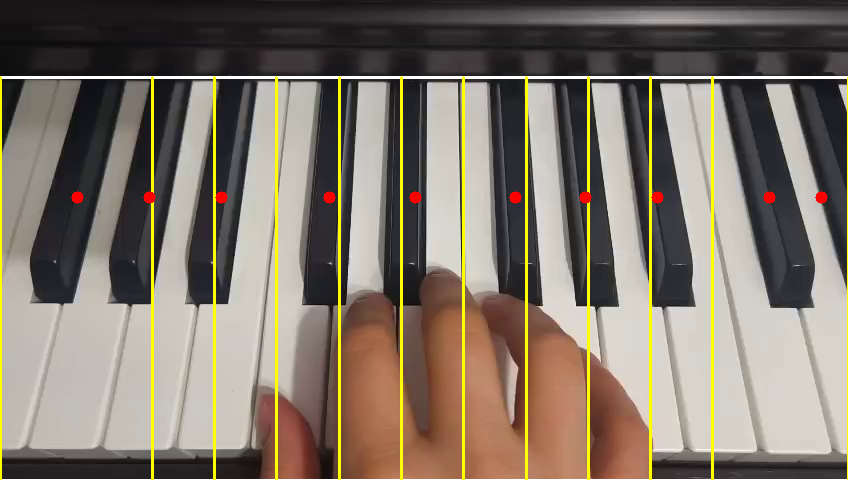

Saved: outputs/white_boundaries_calibrated.png


In [35]:
def equal_boundaries(roi, n_white):
    x,y,w,h = roi
    return np.array([x + i*(w/n_white) for i in range(n_white+1)], dtype=np.float32)

def apply_affine_to_boundaries(boundaries, a, b, roi):
    x,y,w,h = roi
    left, right = x, x+w
    out = a*boundaries + b
    # keep increasing + clip
    out = np.clip(out, left, right)
    out[0] = left
    out[-1] = right
    # enforce monotonicity
    for i in range(1, len(out)):
        if out[i] <= out[i-1] + 1:
            out[i] = out[i-1] + 1
    out[-1] = right
    return out

eqB = equal_boundaries(ROI, N_WHITE_KEYS)
calB = apply_affine_to_boundaries(eqB, a, b, ROI)

# draw
tmp = fr0.copy()
x,y,w,h = ROI
cv2.rectangle(tmp, (x,y), (x+w,y+h), (255,255,255), 2)

# calibrated boundaries in yellow
for bx in calB:
    cv2.line(tmp, (int(bx), y), (int(bx), y+h), (0,255,255), 2)

# also draw detected black centers as red dots for reference (same band)
for bx in black_x2:
    cv2.circle(tmp, (int(bx), y + int(0.30*h)), 6, (0,0,255), -1)

# put labels at each bin center
for k in range(N_WHITE_KEYS):
    cx = int(0.5*(calB[k] + calB[k+1]))
    cv2.putText(tmp, f"{k}:{labels[k]}", (cx-20, y+h+35),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2, cv2.LINE_AA)

outp = "outputs/white_boundaries_calibrated.png"
cv2.imwrite(outp, tmp)
display(Image(outp))
print("Saved:", outp)


In [36]:
def key_index_from_boundaries(px, py, roi, boundaries):
    x,y,w,h = roi
    if px < x or px >= x+w or py < y or py >= y+h:
        return None
    idx = int(np.searchsorted(boundaries, px, side="right") - 1)
    return max(0, min(len(boundaries)-2, idx))

def key_bounds(boundaries, k):
    return int(boundaries[k]), int(boundaries[k+1])


RUN V2

In [37]:
def run(video_path, calB, labels):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError("Could not open video")

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    dt = 1.0 / fps

    # Brightness thresholds (auto-calibration)
    press_th, rel_th = calibrate_thresholds(
        video_path, ROI, N_WHITE_KEYS, BRIGHTNESS_BAND, seconds=3
    )

    bright = KeyBrightnessTracker(ROI, N_WHITE_KEYS, BRIGHTNESS_BAND, EMA_ALPHA)
    states = {f: FingerState() for f in FINGER_TIPS}
    events = []

    out = None
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    frame_idx = 0

    with vision.HandLandmarker.create_from_options(hand_options) as landmarker:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if out is None:
                H, W = frame.shape[:2]
                out = cv2.VideoWriter(OUTPUT_DEBUG_VIDEO, fourcc, fps, (W, H))

            t = frame_idx * dt

            # ----- brightness z-score per key -----
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            z = bright.update(bright.measure(gray))

            # ----- hand detection -----
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = landmarker.detect(
                mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)
            )
            hand = pick_right_hand(res)

            # ----- draw ROI + key boundaries -----
            x,y,w,h = ROI
            cv2.rectangle(frame, (x,y), (x+w,y+h), (255,255,255), 2)

            for k in range(len(calB)-1):
                x0, x1 = key_bounds(calB, k)
                cv2.line(frame, (x0,y), (x0,y+h), (180,180,180), 1)
                cx = (x0+x1)//2
                cv2.putText(
                    frame, f"{k}:{labels[k]}",
                    (cx-20, y+h+28),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2
                )

            # ----- finger logic -----
            if hand is not None:
                Hh, Ww = frame.shape[:2]

                for finger, tip_idx in FINGER_TIPS.items():
                    st = states[finger]
                    tip = hand[tip_idx]

                    px = int(tip.x * Ww)
                    py = int(tip.y * Hh)

                    cv2.circle(frame, (px,py), 6, (0,255,0), -1)

                    key_idx = key_index_from_boundaries(px, py, ROI, calB)

                    # out of keyboard → force release
                    if key_idx is None:
                        if st.is_pressed:
                            offset = t
                            if (offset - st.press_start_time)*1000 >= MIN_HOLD_MS:
                                events.append(
                                    PressEvent(
                                        pitch=st.active_pitch,
                                        onset_s=st.press_start_time,
                                        offset_s=offset,
                                        finger=finger,
                                        key_idx=st.active_key,
                                        label=labels[st.active_key]
                                    )
                                )
                        states[finger] = FingerState()
                        continue

                    # stability streak
                    if key_idx == st.last_key:
                        st.streak += 1
                    else:
                        st.last_key = key_idx
                        st.streak = 1

                    best_k = key_idx
                    best_z = float(z[best_k])

                    pth = press_th[best_k]
                    rth = rel_th[best_k]

                    pitch = midi_pitch_from_label(labels[best_k], OCTAVE_GUESS)

                    # ----- PRESS -----
                    if (not st.is_pressed and
                        st.streak >= STABLE_FRAMES and
                        best_z < pth):

                        st.is_pressed = True
                        st.press_start_time = t
                        st.active_key = best_k
                        st.active_pitch = pitch

                    # ----- RELEASE -----
                    if st.is_pressed and best_z > rth:
                        offset = t
                        if (offset - st.press_start_time)*1000 >= MIN_HOLD_MS:
                            events.append(
                                PressEvent(
                                    pitch=st.active_pitch,
                                    onset_s=st.press_start_time,
                                    offset_s=offset,
                                    finger=finger,
                                    key_idx=st.active_key,
                                    label=labels[st.active_key]
                                )
                            )
                        st.is_pressed = False
                        st.cooldown_until_s = t + COOLDOWN_MS/1000.0

            cv2.putText(
                frame, f"events={len(events)}",
                (20,40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2
            )

            out.write(frame)
            frame_idx += 1

    cap.release()
    out.release()

    # ----- MIDI -----
    pm = pretty_midi.PrettyMIDI()
    inst = pretty_midi.Instrument(program=0)

    for ev in events:
        inst.notes.append(
            pretty_midi.Note(
                velocity=90,
                pitch=int(ev.pitch),
                start=float(ev.onset_s),
                end=max(ev.offset_s, ev.onset_s + 0.02)
            )
        )

    pm.instruments.append(inst)
    pm.write(OUTPUT_MIDI)

    print("Saved:", OUTPUT_DEBUG_VIDEO, OUTPUT_MIDI)
    return events, fps


In [38]:
events, fps = run(VIDEO_PATH, calB, labels)
print("FPS:", fps, "Events:", len(events))


Saved: outputs/debug_overlay.mp4 outputs/output.mid
FPS: 30.004521639488587 Events: 26


In [39]:
import pretty_midi
import numpy as np

def midi_num_to_name(midi_num: int) -> str:
    # pretty_midi already has this helper, but let's keep it explicit
    return pretty_midi.note_number_to_name(int(midi_num))

def print_events_table(events, max_rows=200):
    if not events:
        print("No events to print (events is empty).")
        return

    print(f"Total events: {len(events)}")
    print("idx | finger | key_idx | label | pitch | note_name | onset(s) | offset(s) | dur(ms)")
    print("-"*90)
    for i, ev in enumerate(events[:max_rows]):
        dur_ms = (ev.offset_s - ev.onset_s) * 1000.0
        print(f"{i:3d} | {ev.finger:6s} | {ev.key_idx:6d} | {ev.label:5s} | {ev.pitch:5d} | "
              f"{midi_num_to_name(ev.pitch):8s} | {ev.onset_s:7.3f} | {ev.offset_s:8.3f} | {dur_ms:7.1f}")
    if len(events) > max_rows:
        print(f"... (showing first {max_rows})")

def print_midi_file_notes(midi_path="outputs/output.mid", max_rows=300):
    pm = pretty_midi.PrettyMIDI(midi_path)
    notes = []
    for inst_i, inst in enumerate(pm.instruments):
        for n in inst.notes:
            notes.append((inst_i, n.pitch, n.start, n.end, n.velocity))
    notes.sort(key=lambda x: x[2])  # sort by start time

    print(f"MIDI file: {midi_path}")
    print(f"Total notes in file: {len(notes)}")
    print("idx | inst | pitch | note_name | start(s) | end(s) | dur(ms) | vel")
    print("-"*80)
    for i, (inst_i, pitch, start, end, vel) in enumerate(notes[:max_rows]):
        dur_ms = (end - start) * 1000.0
        print(f"{i:3d} | {inst_i:4d} | {pitch:5d} | {midi_num_to_name(pitch):8s} | "
              f"{start:7.3f} | {end:7.3f} | {dur_ms:7.1f} | {vel:3d}")
    if len(notes) > max_rows:
        print(f"... (showing first {max_rows})")

# 1) From events list (if you have it in memory)
print_events_table(events)

print("\n" + "="*80 + "\n")

# 2) From MIDI file on disk
print_midi_file_notes("outputs/output.mid")


Total events: 26
idx | finger | key_idx | label | pitch | note_name | onset(s) | offset(s) | dur(ms)
------------------------------------------------------------------------------------------
  0 | ring   |      6 | F     |    65 | F4       |   0.233 |    0.467 |   233.3
  1 | ring   |      6 | F     |    65 | F4       |   0.567 |    0.767 |   200.0
  2 | index  |      4 | D     |    62 | D4       |   1.633 |    1.766 |   133.3
  3 | middle |      5 | E     |    64 | E4       |   1.766 |    2.333 |   566.6
  4 | ring   |      6 | F     |    65 | F4       |   2.100 |    2.333 |   233.3
  5 | middle |      5 | E     |    64 | E4       |   2.433 |    2.600 |   166.6
  6 | index  |      4 | D     |    62 | D4       |   2.366 |    2.733 |   366.6
  7 | index  |      4 | D     |    62 | D4       |   2.900 |    3.033 |   133.3
  8 | middle |      5 | E     |    64 | E4       |   3.266 |    3.899 |   633.2
  9 | index  |      4 | D     |    62 | D4       |   3.300 |    4.166 |   866.5
 10 | ri